# GP Fitting
Author: Allen Ross  
Date: 5/18/21  

## Setup

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import gpflow
from gpflow.utilities import print_summary, set_trainable
# %matplotlib 
# plt.ioff()

In [112]:
# Helper functions
def gp_predict_fun(gp, X, x_min, x_max, x_idx, unit_idx, unit_label, num_funs=10):  
    """
    Plot marginal closed-form posterior distribution.
    """
    
    # Create test points
    x_new = np.zeros_like(X)
    x_new[:,x_idx] = np.linspace(x_min, x_max, X.shape[0])
    x_new[:, unit_idx] = unit_label

    # Predict mean and variance on new data
    mean, var = gp.predict_f(x_new)

    # Pull some posterior functions
    tf.random.set_seed(1) 
    samples = gp.predict_f_samples(x_new, num_funs) 

    # Generate plot
#     p = plt.figure(figsize=(10, 5))
    fig, ax = plt.subplots(figsize=(10,5))
    p = sns.scatterplot(x=X[:,x_idx],
                    y=Y.flatten(),
                    hue=X[:,unit_idx].astype(int).astype(str),
                        legend=False)
    p = sns.lineplot(x=x_new[:,x_idx],
                 y=mean.numpy().flatten(),
                 linewidth=2,
                    color='darkgreen')
    p.fill_between(
        x_new[:, x_idx],
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        color='lightgreen',
        alpha=0.5,
    )
    p.plot(x_new[:,x_idx], 
           samples[:, :, 0].numpy().T,# "C0", 
           color='dimgray',
           linewidth=0.5)
#     plt.close()
    return(p)

def calc_bic(loglik, n, k):
    return k*np.log(n)-2*loglik

# Kernel search helper functions
def coregion_freeze(k):
    """ Freeze parameters associated with coregion kernel, for individual level effets. """
    
    if k.name == 'coregion':
        print('Found coregion kernel, freezing parameters.')
        k.W.assign(np.zeros_like(k.W))
        set_trainable(k.W, False)
#         set_trainable(k, False)

def coregion_search(kern_list):
    """ Search through GP kernel list to find coregion kernels. """
    
    for k in kern_list:
        if hasattr(k, 'kernels'):
            coregion_search(k.kernels)
        else:
            coregion_freeze(k)

def print_kernel_names(kernel):
    names = []
    if hasattr(kernel,'kernels')==False:
        return kernel.name
    for i in kernel.kernels:
        if i.name == 'sum':
            sub_names = print_kernel_names(i)
#             names.append('+'.join([x.name for x in i.kernels]))
            names.append('+'.join(sub_names))

        elif i.name == 'product':
            sub_names = print_kernel_names(i)
#             names.append('*'.join([x.name for x in i.kernels]))
            names.append('*'.join(sub_names))

        else:
            names.append(i.name)

    return(names)

def kernel_test(X, Y, k, no_tune=None):
    """
    This function evaluates a particular kernel selection on a set of data. 
    
    Inputs:
        X (array): design matrix
        Y (array): output matrix
        k (gpflow kernel): specified kernel
        
    Outputs:
        m (gpflow model): fitted GPflow model
    
    """
    # Specify model
    m = gpflow.models.GPR(data=(X, Y),
                          kernel=k,
                          mean_function=None)
    
    # Check if some parameters shouldn't be trained
    if no_tune:
        for p in no_tune:
            set_trainable(m.kernel.kernels[p], False)
    
    # Optimization step for hyperparameters
    gpflow.optimizers.Scipy().minimize(m.training_loss,
                                       m.trainable_variables)
    
    # Plot marginal outputs
#     p = gp_predict_fun(gp=m, X=X, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0)

#     print(f'Log marginal likelihood: {m.log_marginal_likelihood().numpy()}')
    # Calculate information criteria
    bic = round(calc_bic(loglik=m.log_marginal_likelihood().numpy(),
                   n=X.shape[0],
                   k=len(m.parameters)),
               2)
    print(f'Model: {print_kernel_names(k)}, BIC: {bic}')
    
    # Return fitted GP model, plot, and bic
    return(m,# p, 
           bic)

### Read Data

In [113]:
# Read data in
df = pd.read_csv('simulated_data.csv')
X = df[['unit', 'treatment', 'time']].to_numpy().reshape(-1,3)
Y = df[['k1_obs']].to_numpy().reshape(-1,1)
df.head()

,unit,treatment,time,k1_obs,k2_obs,k3_obs,k4_obs
0,0.0,0.0,0.0,0.85,1.41,0.54,40.94
1,0.0,0.0,1.4,1.12,0.68,1.42,42.18
2,0.0,0.0,2.0,1.18,0.91,1.68,42.72
3,0.0,0.0,2.4,1.12,0.95,2.12,43.10
4,0.0,0.0,3.4,0.45,0.31,2.80,43.44


### Fit Separate Models

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.17392  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.747315 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.453631 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧══════

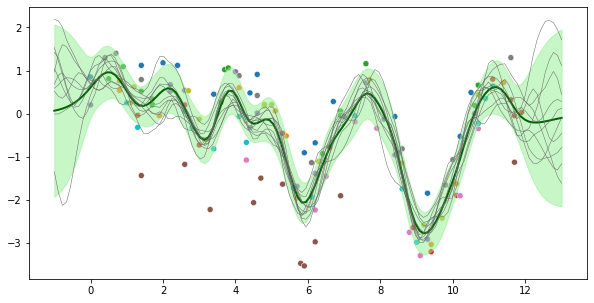

In [114]:
# Fit overall model with time only kernel function
k = gpflow.kernels.Matern52(active_dims=[2])
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
opt_logs = gpflow.optimizers.Scipy().minimize(m.training_loss, 
                                              m.trainable_variables, 
                                              options=dict(maxiter=100))
print_summary(m)
p = gp_predict_fun(gp=m, X=X, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0)
print(f'Log marginal likelihood: {m.log_marginal_likelihood().numpy()}')
bic = calc_bic(loglik=m.log_marginal_likelihood().numpy(),
               n=X.shape[0],
               k=len(m.trainable_parameters))
print(f'BIC: {bic}')

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                                 │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.5391053548189577                    │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.907563442878393                     │
├────────────────────────────────────┼───────────┼──────────────────┼───────

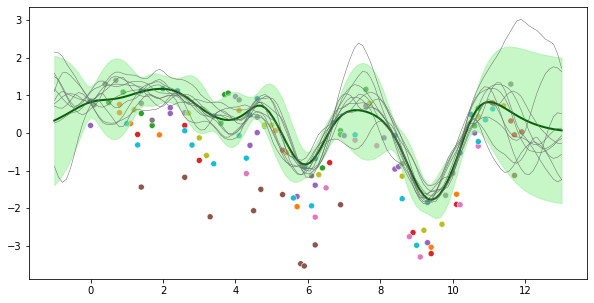

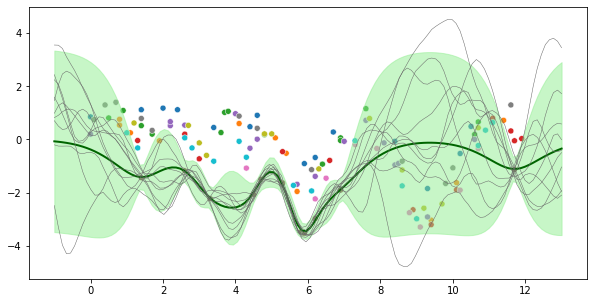

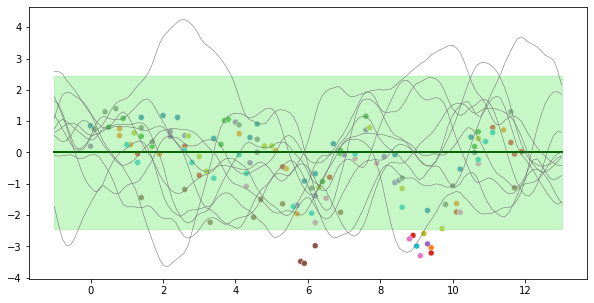

In [115]:
# Fit GP model with individual level effects
k = (gpflow.kernels.Matern52(active_dims=[2]) * 
    gpflow.kernels.Coregion(output_dim=len(np.unique(X[:,0]))+1,
                            rank=1,active_dims=[0]))
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)

# Deal with coregion kernel
m.kernel.kernels[1].W.assign(np.zeros_like(m.kernel.kernels[1].W))
set_trainable(m.kernel.kernels[1].W, False)
opt_logs = gpflow.optimizers.Scipy().minimize(m.training_loss, 
                                              m.trainable_variables, 
                                              options=dict(maxiter=100))
print_summary(m)
gp_predict_fun(gp=m, X=X, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0)
gp_predict_fun(gp=m, X=X, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=5)
gp_predict_fun(gp=m, X=X, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=10)
print(f'Log marginal likelihood: {m.log_marginal_likelihood().numpy()}')
bic = calc_bic(loglik=m.log_marginal_likelihood().numpy(),
               n=X.shape[0],
               k=len(m.trainable_parameters))
print(f'BIC: {bic}')

B = [[0.6368008  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         1.44628097 0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.46389028 0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.0181089  0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.94414501 0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.98370232
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.55709434 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.61182431 0.         0.         0.        ]
 [0.         0.         0.         0.       

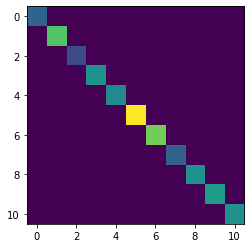

In [116]:
B = m.kernel.kernels[1].output_covariance().numpy()
print("B =", B)
_ = plt.imshow(B)

### Kernel Search
Now we need to specify the kernels we want to test

In [117]:
kernel_list = [gpflow.kernels.Constant(active_dims=[2]),
               gpflow.kernels.Linear(active_dims=[2]),
               gpflow.kernels.Matern32(active_dims=[2]),
               #gpflow.kernels.Periodic(),
               gpflow.kernels.SquaredExponential(active_dims=[2]),
               gpflow.kernels.White(active_dims=[2])]

# Loop through kernels for single dimension test first
best_kern = None
best_bic = np.Inf
for k in kernel_list:
    m,bic = kernel_test(X, Y, k)
    if bic < best_bic:
        best_kern = k
        best_bic = bic
print(f'Best BIC: {best_bic}, kernel: {best_kern.name}')

Model: constant, BIC: 422.11
Model: linear, BIC: 408.15
Model: matern32, BIC: 322.72
Model: squared_exponential, BIC: 321.7
Model: white, BIC: 434.63
Best BIC: 321.7, kernel: squared_exponential


In [118]:
# Now try to add individual effects
best_kern = None
best_bic = np.Inf
for k in kernel_list:
    k = k + gpflow.kernels.Coregion(
                output_dim=len(np.unique(X[:,0])),
                rank=1,active_dims=[0])
    coregion_search(k.kernels)
    m,bic = kernel_test(X, Y, k, no_tune=[1])
    if bic < best_bic:
        best_kern = k
        best_bic = bic
print(f'Best BIC: {best_bic}, kernel: {print_kernel_names(best_kern)}')

Found coregion kernel, freezing parameters.
Model: ['constant', 'coregion'], BIC: 408.27
Found coregion kernel, freezing parameters.
Model: ['linear', 'coregion'], BIC: 394.22
Found coregion kernel, freezing parameters.
Model: ['matern32', 'coregion'], BIC: 41.28
Found coregion kernel, freezing parameters.
Model: ['squared_exponential', 'coregion'], BIC: 50.51
Found coregion kernel, freezing parameters.
Model: ['white', 'coregion'], BIC: 408.83
Best BIC: 41.28, kernel: ['matern32', 'coregion']


In [119]:
# Now try to add individual effects and individual slope effects
best_kern = None
best_bic = np.Inf
for k in kernel_list:
    k = (k * gpflow.kernels.Coregion(
                output_dim=len(np.unique(X[:,0])),
                rank=1,active_dims=[0]) + 
        gpflow.kernels.Coregion(
                output_dim=len(np.unique(X[:,0])),
                rank=1,active_dims=[0]))
    coregion_search(k.kernels)
    m,bic = kernel_test(X, Y, k)
    if bic < best_bic:
        best_kern = k
        best_bic = bic
print(f'Best BIC: {best_bic}, kernel: {print_kernel_names(best_kern)}')

Found coregion kernel, freezing parameters.
Found coregion kernel, freezing parameters.
Model: ['constant*coregion', 'coregion'], BIC: 407.26
Found coregion kernel, freezing parameters.
Found coregion kernel, freezing parameters.
Model: ['linear*coregion', 'coregion'], BIC: 401.84
Found coregion kernel, freezing parameters.
Found coregion kernel, freezing parameters.
Model: ['matern32*coregion', 'coregion'], BIC: 331.51
Found coregion kernel, freezing parameters.
Found coregion kernel, freezing parameters.
Model: ['squared_exponential*coregion', 'coregion'], BIC: 327.87
Found coregion kernel, freezing parameters.
Found coregion kernel, freezing parameters.
Model: ['white*coregion', 'coregion'], BIC: 397.66
Best BIC: 327.87, kernel: ['squared_exponential*coregion', 'coregion']


Model: constant, BIC: 422.11
Found coregion kernel, freezing parameters.
Model: ['constant', 'coregion'], BIC: 397.59
Model: linear, BIC: 408.15
Found coregion kernel, freezing parameters.
Model: ['linear', 'coregion'], BIC: 402.1
Model: matern32, BIC: 322.72
Found coregion kernel, freezing parameters.
Model: ['matern32', 'coregion'], BIC: 328.22
Model: squared_exponential, BIC: 321.7
Found coregion kernel, freezing parameters.
Model: ['squared_exponential', 'coregion'], BIC: 323.88
Model: white, BIC: 434.63
Found coregion kernel, freezing parameters.
Model: ['white', 'coregion'], BIC: 421.23
Best kernel from round 0 is squared_exponential with bic 321.7
Found better kernel in next layer

Model: ['squared_exponential', 'constant'], BIC: 326.54
Found coregion kernel, freezing parameters.
Model: ['squared_exponential', 'constant*coregion'], BIC: 39.69
Model: ['squared_exponential', 'linear'], BIC: 326.0
Found coregion kernel, freezing parameters.
Model: ['squared_exponential', 'linear*co

'squared_exponential+constant*coregion'

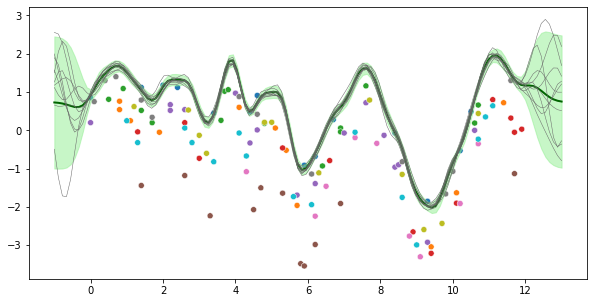

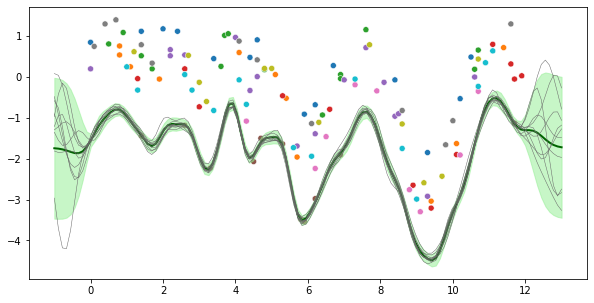

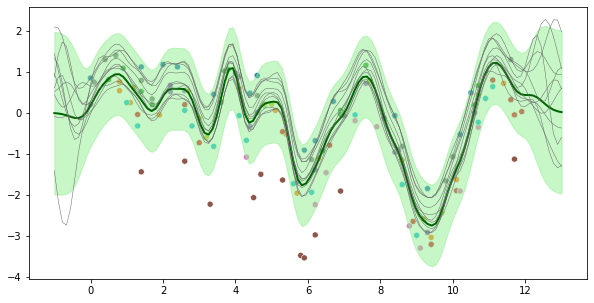

In [120]:
# Put it all together
# Search through marginal effects, individual offsets, and individual slopes
np.random.seed(9012)
max_depth = 3
best_kern = None
best_bic = np.Inf
best_bic_last_round = np.Inf
best_model = None
k_best = None
for d in range(max_depth):
    for k in kernel_list:
#         print(print_kernel_names(k))
        for i in range(2):
            if i == 1:
                k_new = (k * gpflow.kernels.Coregion(
                       output_dim=len(np.unique(X[:,0]))+1,
                       rank=1,active_dims=[0])) 
                coregion_search(k_new.kernels)
            else:
                k_new = k
            
            # Attach best previous kernel
            if k_best!=None:
                k_new = k_best + k_new

            # Randomize initial values
            for p in k_new.trainable_parameters:
                p.assign(np.random.uniform(
                    size=p.numpy().size).reshape(p.numpy().shape)
                        )
            # Run kernel test
            m,bic = kernel_test(X, Y, k_new)
            if bic < best_bic:
                best_kern = k_new
                best_bic = bic
                best_model = m
    # Save best kernel from round
    print(f'Best kernel from round {d} is {best_kern.name} with bic {best_bic}')
    
    # See if we have done better than the previous round
    if best_bic < best_bic_last_round:
        print(f'Found better kernel in next layer\n')
        best_bic_last_round = best_bic
        k_best = best_kern
    else:
        print(f'No better kernels, stopping search\n')
        break
        
# Fit final model
m,bic = kernel_test(X, Y, best_kern)
gp_predict_fun(gp=m, X=X, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0);
gp_predict_fun(gp=m, X=X, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=5);
gp_predict_fun(gp=m, X=X, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=10);
'+'.join(print_kernel_names(best_kern))

In [121]:
best_model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.7733266417902641
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.3637176841831295
GPR.kernel.kernels[1].kernels[0].variance,Parameter,Softplus,,True,(),float64,0.3507514773575742
GPR.kernel.kernels[1].kernels[1].W,Parameter,Identity,,False,"(11, 1)",float64,[[0....
GPR.kernel.kernels[1].kernels[1].kappa,Parameter,Softplus,,True,"(11,)",float64,"[1.54288473e+00, 2.09041385e-01, 3.70341994e-02..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.01247985901712887


B = [[1.54288473e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.09041385e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.70341994e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.10251905e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.37089274e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 8.61369451e+00 0.00000000e+00 0.00000000e+00
  0.00000000

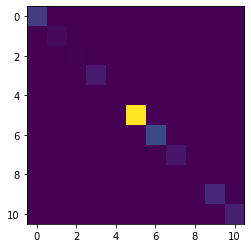

In [96]:
B = m.kernel.kernels[1].kernels[1].output_covariance().numpy()
print("B =", B)
_ = plt.imshow(B)

Kernel 2

Model: constant, BIC: 432.63
Found coregion kernel, freezing parameters.
Model: ['constant', 'coregion'], BIC: 387.5
Model: linear, BIC: 437.52
Found coregion kernel, freezing parameters.
Model: ['linear', 'coregion'], BIC: 399.75
Model: matern32, BIC: 437.42
Found coregion kernel, freezing parameters.
Model: ['matern32', 'coregion'], BIC: 222.94
Model: squared_exponential, BIC: 438.19
Found coregion kernel, freezing parameters.
Model: ['squared_exponential', 'coregion'], BIC: 230.88
Model: white, BIC: 461.29
Found coregion kernel, freezing parameters.
Model: ['white', 'coregion'], BIC: 449.29
Best kernel from round 0 is product with bic 222.94
Found better kernel in next layer

Model: ['matern32*coregion', 'constant'], BIC: 227.27
Found coregion kernel, freezing parameters.
Model: ['matern32*coregion', 'constant*coregion'], BIC: 230.11
Model: ['matern32*coregion', 'linear'], BIC: 227.78
Found coregion kernel, freezing parameters.
Model: ['matern32*coregion', 'linear*coregion'], BIC: 2

'matern32*coregion+matern32'

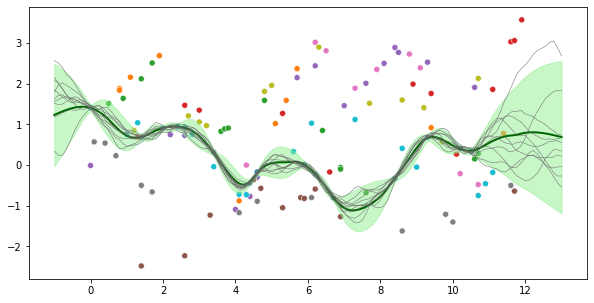

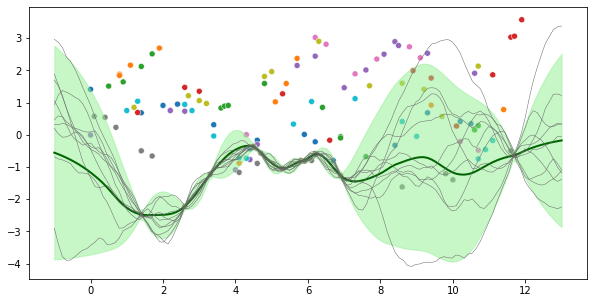

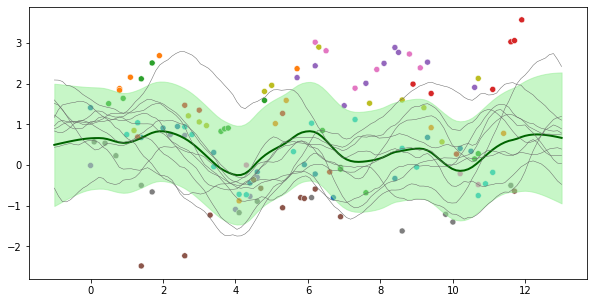

In [122]:
# Put it all together
# Search through marginal effects, individual offsets, and individual slopes
np.random.seed(9012)
X = df[['unit', 'treatment', 'time']].to_numpy().reshape(-1,3)
Y = df[['k2_obs']].to_numpy().reshape(-1,1)
max_depth = 3
best_kern = None
best_bic = np.Inf
best_bic_last_round = np.Inf
best_model = None
k_best = None
for d in range(max_depth):
    for k in kernel_list:
#         print(print_kernel_names(k))
        for i in range(2):
            if i == 1:
                k_new = (k * gpflow.kernels.Coregion(
                       output_dim=len(np.unique(X[:,0]))+1,
                       rank=1,active_dims=[0])) 
                coregion_search(k_new.kernels)
            else:
                k_new = k
            
            # Attach best previous kernel
            if k_best!=None:
                k_new = k_best + k_new

            # Randomize initial values
            for p in k_new.trainable_parameters:
                p.assign(np.random.uniform(
                    size=p.numpy().size).reshape(p.numpy().shape)
                        )
            # Run kernel test
            m,bic = kernel_test(X, Y, k_new)
            if bic < best_bic:
                best_kern = k_new
                best_bic = bic
                best_model = m
    # Save best kernel from round
    print(f'Best kernel from round {d} is {best_kern.name} with bic {best_bic}')
    
    # See if we have done better than the previous round
    if best_bic < best_bic_last_round:
        print(f'Found better kernel in next layer\n')
        best_bic_last_round = best_bic
        k_best = best_kern
    else:
        print(f'No better kernels, stopping search\n')
        break
        
# Fit final model
m,bic = kernel_test(X, Y, best_kern)
gp_predict_fun(gp=m, X=X, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0);
gp_predict_fun(gp=m, X=X, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=5);
gp_predict_fun(gp=m, X=X, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=10);
'+'.join(print_kernel_names(best_kern))

Kernel 3

Model: constant, BIC: 572.33
Found coregion kernel, freezing parameters.
Model: ['constant', 'coregion'], BIC: 572.06
Model: linear, BIC: 424.24
Found coregion kernel, freezing parameters.
Model: ['linear', 'coregion'], BIC: 213.79
Model: matern32, BIC: 438.31
Found coregion kernel, freezing parameters.
Model: ['matern32', 'coregion'], BIC: 42.71
Model: squared_exponential, BIC: 436.35
Found coregion kernel, freezing parameters.
Model: ['squared_exponential', 'coregion'], BIC: 12.25
Model: white, BIC: 705.78
Found coregion kernel, freezing parameters.
Model: ['white', 'coregion'], BIC: 681.28
Best kernel from round 0 is product with bic 12.25
Found better kernel in next layer

Model: ['squared_exponential*coregion', 'constant'], BIC: 16.01
Found coregion kernel, freezing parameters.
Model: ['squared_exponential*coregion', 'constant*coregion'], BIC: 26.76
Model: ['squared_exponential*coregion', 'linear'], BIC: -93.48
Found coregion kernel, freezing parameters.
Model: ['squared_exponenti

'squared_exponential*coregion+linear+linear*coregion'

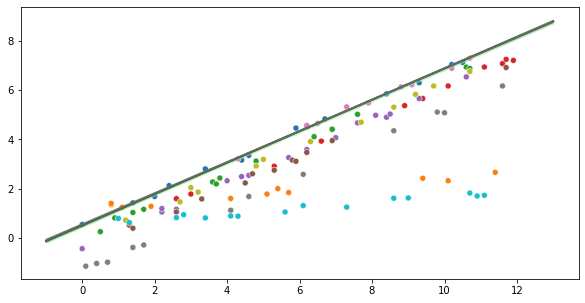

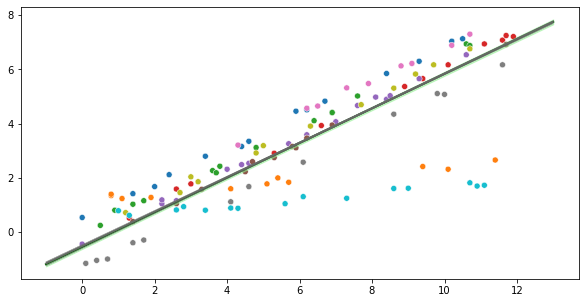

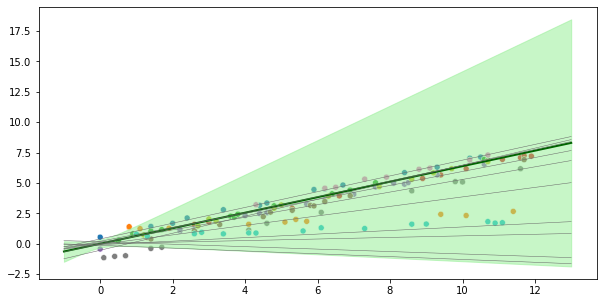

In [127]:
# Put it all together
# Search through marginal effects, individual offsets, and individual slopes
np.random.seed(9012)
X = df[['unit', 'treatment', 'time']].to_numpy().reshape(-1,3)
Y = df[['k3_obs']].to_numpy().reshape(-1,1)
max_depth = 3
best_kern = None
best_bic = np.Inf
best_bic_last_round = np.Inf
best_model = None
k_best = None
for d in range(max_depth):
    for k in kernel_list:
#         print(print_kernel_names(k))
        for i in range(2):
            if i == 1:
                k_new = (k * gpflow.kernels.Coregion(
                       output_dim=len(np.unique(X[:,0]))+1,
                       rank=1,active_dims=[0])) 
                coregion_search(k_new.kernels)
            else:
                k_new = k
            
            # Attach best previous kernel
            if k_best!=None:
                k_new = k_best + k_new

            # Randomize initial values
            for p in k_new.trainable_parameters:
                p.assign(np.random.uniform(
                    size=p.numpy().size).reshape(p.numpy().shape)
                        )
            # Run kernel test
            try:
                m,bic = kernel_test(X, Y, k_new)
            except:# InvalidArgumentError:
                print('Invalid matrix input, skipping')
                break
            if bic < best_bic:
                best_kern = k_new
                best_bic = bic
                best_model = m
    # Save best kernel from round
    print(f'Best kernel from round {d} is {best_kern.name} with bic {best_bic}')
    
    # See if we have done better than the previous round
    if best_bic < best_bic_last_round:
        print(f'Found better kernel in next layer\n')
        best_bic_last_round = best_bic
        k_best = best_kern
    else:
        print(f'No better kernels, stopping search\n')
        break
        
# Fit final model
m,bic = kernel_test(X, Y, best_kern)
gp_predict_fun(gp=m, X=X, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0);
gp_predict_fun(gp=m, X=X, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=5);
gp_predict_fun(gp=m, X=X, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=10);
'+'.join(print_kernel_names(best_kern))